In [2]:
import pandas as pd
import numpy as np
import kaggle
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 1) Import Heart Disease from Kaggle

In [36]:
!kaggle datasets download ronitf/heart-disease-uci -f heart.csv

heart.csv: Skipping, found more recently modified local copy (use --force to force download)


### Explore and clean dataset

In [40]:
# store observations in a dataframe

hd = pd.read_csv("heart.csv")
hd.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [41]:
hd.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


The column headers are not inherently clear. Here is a deeper explanation of each variable:

__age__: age in years
__sex__: gender 
    -- Value 1: male
    -- Value 0: female
__cp__: chest pain type **ERROR**
    -- Value 1: typical angina 
    -- Value 2: atypical angina 
    -- Value 3: non-anginal pain 
    -- Value 4: asymptomatic
__trestbps__: resting blood pressure (in mm Hg on admission to the hospital)
__chol__: serum cholestorol in mg/dl
__fbs__: fasting blood sugar > 120 mg/dl
    -- Value 1: true
    -- Value 0: false
__restecg__: resting electrocardiographic results 
    -- Value 0: normal 
    -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 20 ekgmo (month of exercise ECG reading)
__thalach__: maximum heart rate achieved
__exang__: exercise induced angina (type of chest pain)
    -- Value 1: yes
    -- Value 2: no
__oldpeak__: ST depression induced by exercise relative to rest (a finding on an ecg where the trace in the ST segment is abnormally low below the baseline)
__slope__: the slope of the peak exercise ST segment (again, related to the ecg) **ERROR**
    -- Value 1: upsloping 
    -- Value 2: flat 
    -- Value 3: downsloping 
__ca__: number of major vessels (0-3) colored by fluoroscopy
__thal__: I believe this refers to thalassemia (though I could not find confirmation), an inherited blood disorder characterized by less hemoglobin and fewer red blood cells in your body than normal **ERROR**
    -- Value 3: normal
    -- Value 6: fixed defect
    -- Value 7: reversable defect
__target__: the predicted attribute - diagnosis of heart disease (angiographic disease status) 
    -- Value 0: < 50% diameter narrowing 
    -- Value 1: > 50% diameter narrowing

Upon reviewing these definitions it is immediately clear that some categorical features (sex, cp, fbs, restecg, exang, slope, thal) are represented numerically. It is important that the models do not interpret these values as ordinal. 

In [42]:
# Convert categorical feature values to characters for increased interpetability and to prevent use as ordinal values

pd.set_option('mode.chained_assignment', None)

hd['sex'][hd['sex'] == 1] = 'male'
hd['sex'][hd['sex'] == 0] = 'female'

hd['cp'][hd['cp'] == 1] = 'typical angina'
hd['cp'][hd['cp'] == 2] = 'atypical angina'
hd['cp'][hd['cp'] == 3] = 'non-anginal pain'
hd['cp'][hd['cp'] == 4] = 'asymptomatic'

hd['fbs'][hd['fbs'] == 1] = 'fasting blood sugar gt 120 mg per dl'
hd['fbs'][hd['fbs'] == 0] = 'fasting blood sugar ltoe 120 mg per dl'

hd['restecg'][hd['restecg'] == 0] = 'normal'
hd['restecg'][hd['restecg'] == 1] = 'ST-T wave abnormality'
hd['restecg'][hd['restecg'] == 2] = 'probable left ventricular hypertrophy'

hd['exang'][hd['exang'] == 1] = 'yes'
hd['exang'][hd['exang'] == 0] = 'no'

hd['slope'][hd['slope'] == 1] = 'upsloping'
hd['slope'][hd['slope'] == 2] = 'flat'
hd['slope'][hd['slope'] == 3] = 'downsloping'

hd['thal'][hd['thal'] == 3] = 'normal'
hd['thal'][hd['thal'] == 6] = 'fixed defect'
hd['thal'][hd['thal'] == 7] = 'reversable defect'

In [43]:
# create clearer column names

hd.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar',
              'restecg','max_heart_rate', 'exercise_induced_angina', 'st_depression', 'st_slope',
              'vessels_colored', 'thalassemia', 'target']

In [44]:
# One-hot encode the categorical variables
pd.set_option('display.max_columns', 27)
hd = pd.get_dummies(hd, drop_first=False)
hd.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate,st_depression,vessels_colored,target,sex_female,sex_male,chest_pain_type_0,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_fasting blood sugar gt 120 mg per dl,fasting_blood_sugar_fasting blood sugar ltoe 120 mg per dl,restecg_ST-T wave abnormality,restecg_normal,restecg_probable left ventricular hypertrophy,exercise_induced_angina_no,exercise_induced_angina_yes,st_slope_0,st_slope_flat,st_slope_upsloping,thalassemia_0,thalassemia_1,thalassemia_2,thalassemia_normal
0,63,145,233,150,2.3,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
3,56,120,236,178,0.8,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,1,0
4,57,120,354,163,0.6,0,1,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0


An issue becomes clear if we look closely at the above output. Despite converting all of our categorical feature values to characters, some are displaying numbers in their one-hot encoded variable names (chest_pain_type_0, st_slope_0, thalassemia_0, etc.).

It appears the dictionary we were provided for the data does not exactly match the data itself. 

    -- chest pain is supposed to take values 1-4, but actually takes values 0-3
    -- st slope is supposed to take values 1-3, but actually takes values 0-2
    -- thalassemia is supposed to take values 3, 6, 7, but actually takes values 0, 1, 2, 3
 
To be cautious, we will not assume the meaning of specific values for these three features. We will use the features in the model, but will not have interpretability until confirmation of the meaning of each value is obtained from the provider of the data. 

In [47]:
hd.rename(columns={'chest_pain_type_typical angina': 'chest_pain_type_1',
                   'chest_pain_type_atypical angina': 'chest_pain_type_2',
                   'chest_pain_type_non-anginal pain': 'chest_pain_type_3'}, inplace=True)

hd.rename(columns={'st_slope_unsloping': 'st_slope_1',
                   'st_slope_flat': 'st_slope_2'}, inplace=True)

hd.rename(columns={'thalassemia_normal': 'thalassemia_3'}, inplace=True)

In [48]:
pd.set_option('display.max_columns', 27)
hd.describe()
# note - there are only 303 observations in the dataset

,age,resting_blood_pressure,cholesterol,max_heart_rate,st_depression,vessels_colored,target,sex_female,sex_male,chest_pain_type_0,chest_pain_type_2,chest_pain_type_3,chest_pain_type_1,fasting_blood_sugar_fasting blood sugar gt 120 mg per dl,fasting_blood_sugar_fasting blood sugar ltoe 120 mg per dl,restecg_ST-T wave abnormality,restecg_normal,restecg_probable left ventricular hypertrophy,exercise_induced_angina_no,exercise_induced_angina_yes,st_slope_0,st_slope_2,st_slope_upsloping,thalassemia_0,thalassemia_1,thalassemia_2,thalassemia_3
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.729373,0.544554,0.316832,0.683168,0.471947,0.287129,0.075908,0.165017,0.148515,0.851485,0.501650,0.485149,0.013201,0.673267,0.326733,0.069307,0.468647,0.462046,0.006601,0.059406,0.547855,0.386139
std,9.082101,17.538143,51.830751,22.905161,1.161075,1.022606,0.498835,0.466011,0.466011,0.500038,0.453171,0.265288,0.371809,0.356198,0.356198,0.500824,0.500606,0.114325,0.469794,0.469794,0.254395,0.499842,0.499382,0.081110,0.236774,0.498528,0.487668
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
# check for nulls

hd.isna().sum()

age                                                           0
resting_blood_pressure                                        0
cholesterol                                                   0
max_heart_rate                                                0
st_depression                                                 0
vessels_colored                                               0
target                                                        0
sex_female                                                    0
sex_male                                                      0
chest_pain_type_0                                             0
chest_pain_type_2                                             0
chest_pain_type_3                                             0
chest_pain_type_1                                             0
fasting_blood_sugar_fasting blood sugar gt 120 mg per dl      0
fasting_blood_sugar_fasting blood sugar ltoe 120 mg per dl    0
restecg_ST-T wave abnormality           

C:\Users\Eric\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


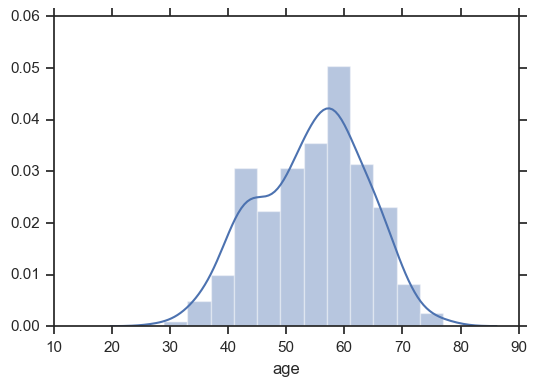

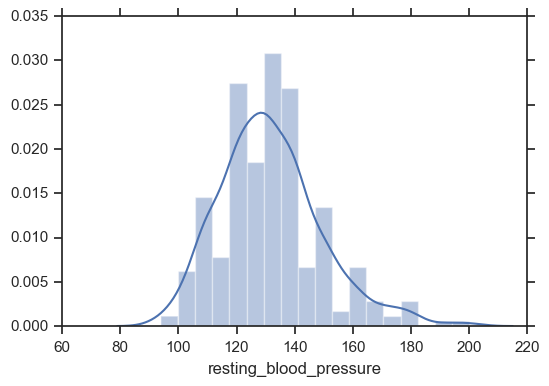

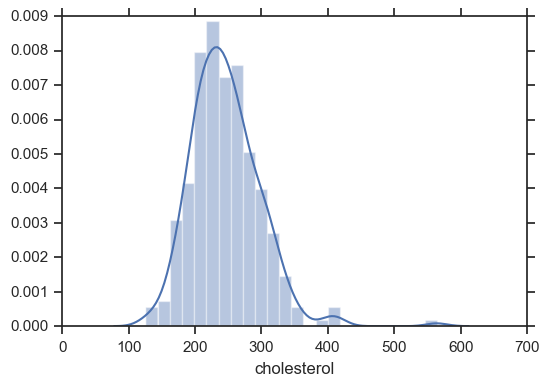

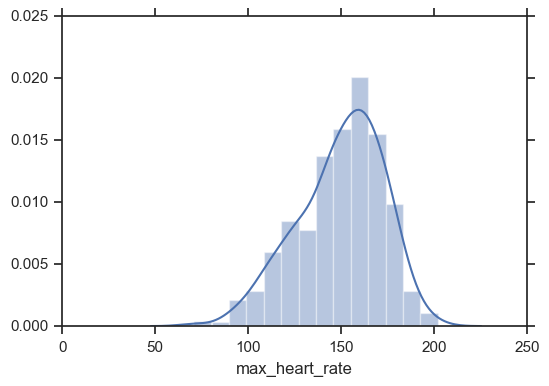

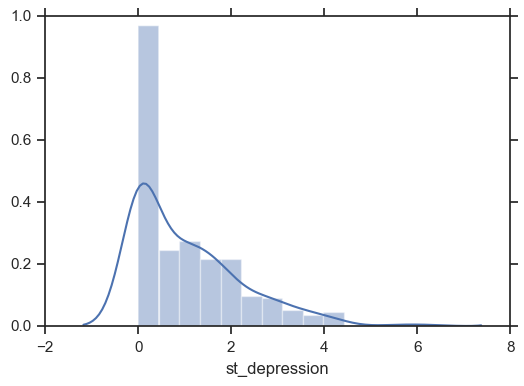

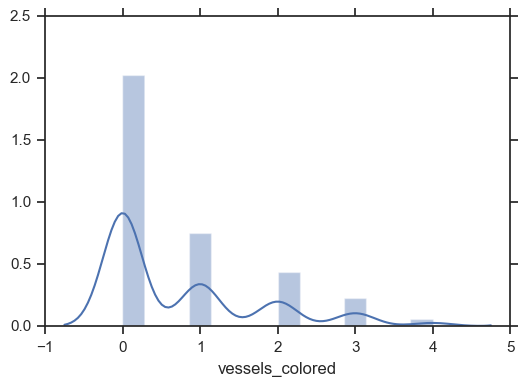

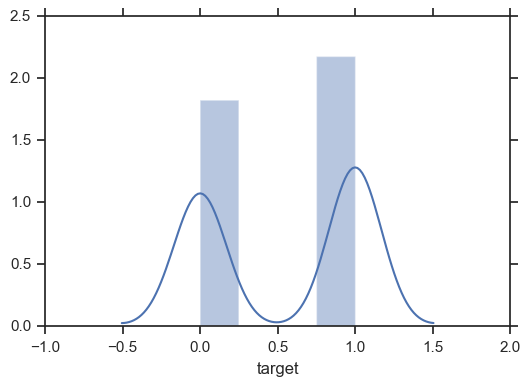

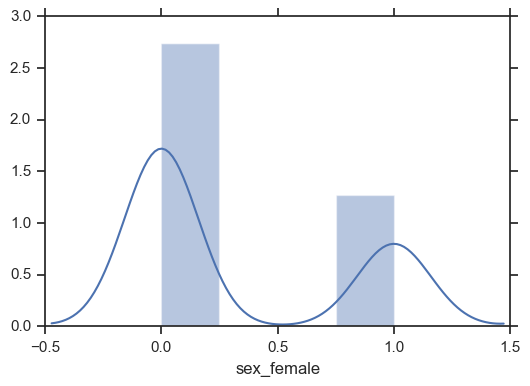

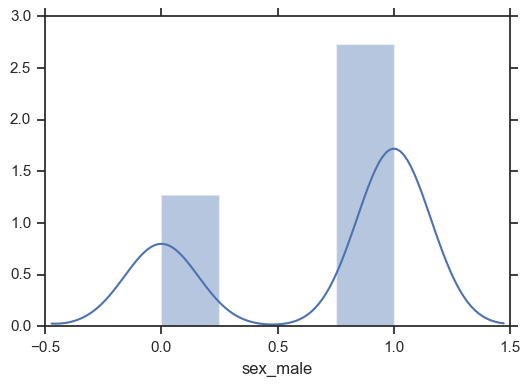

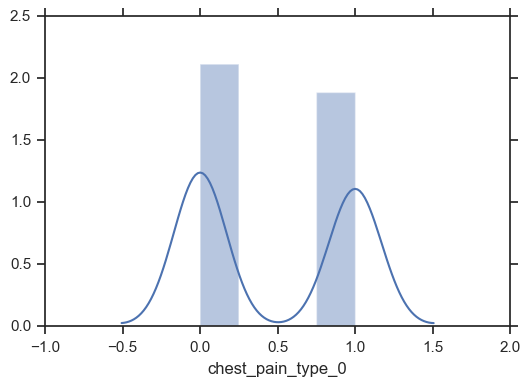

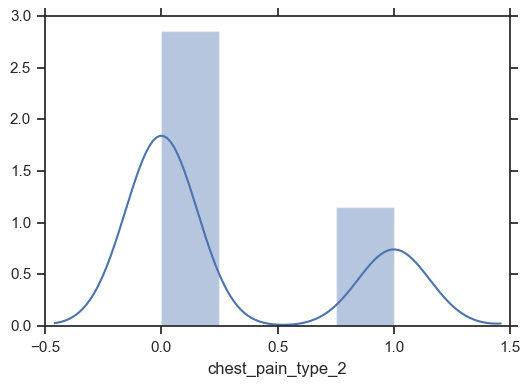

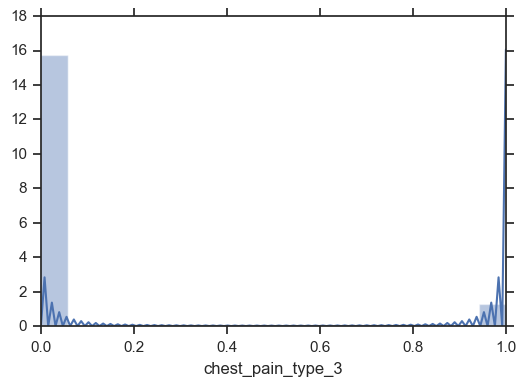

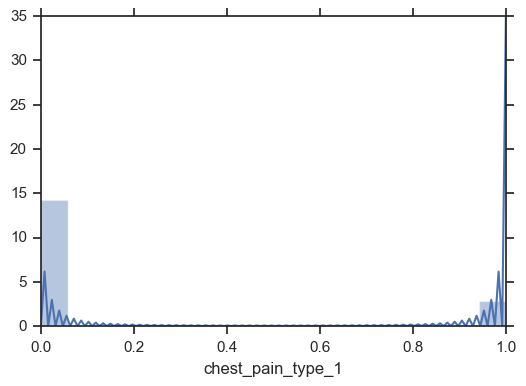

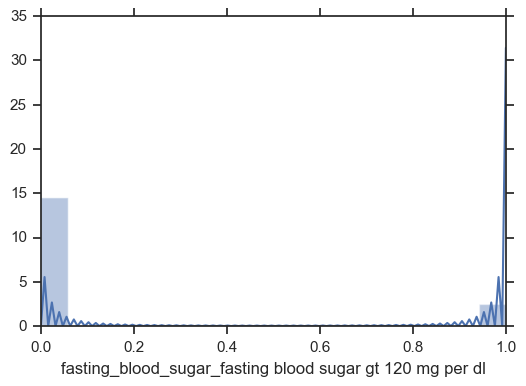

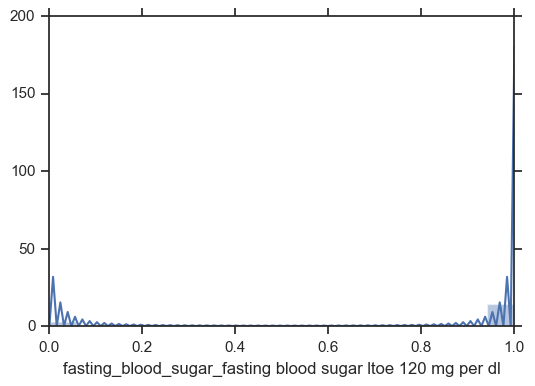

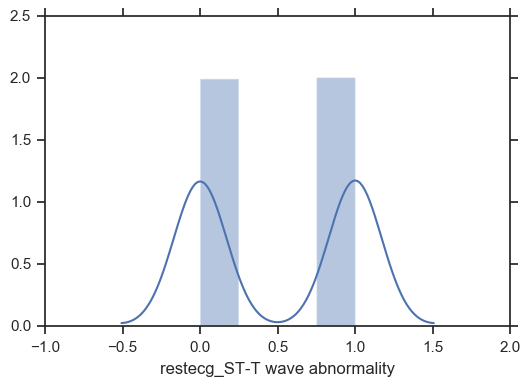

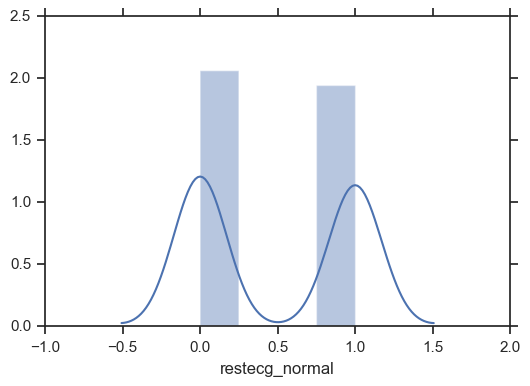

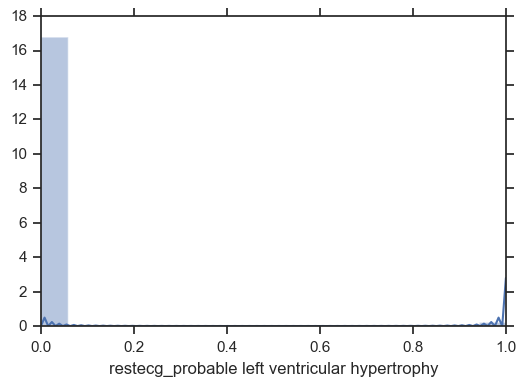

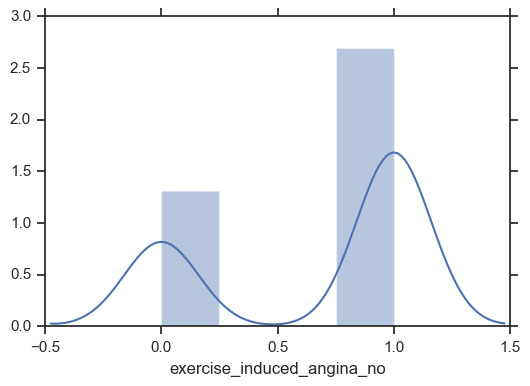

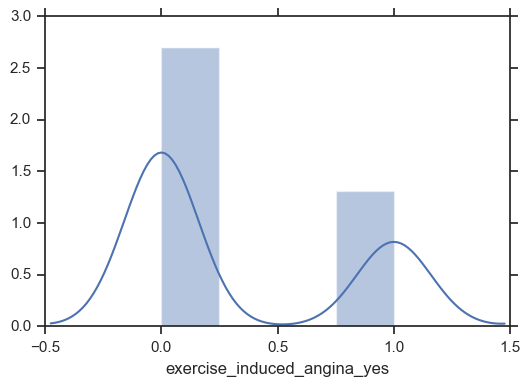

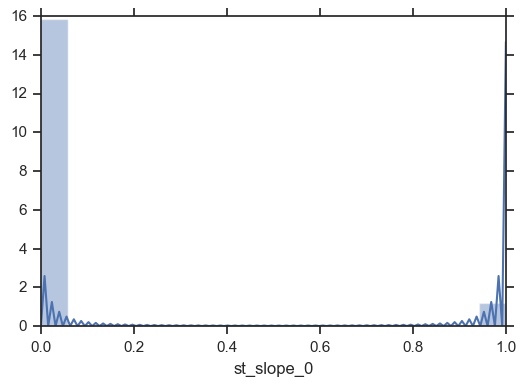

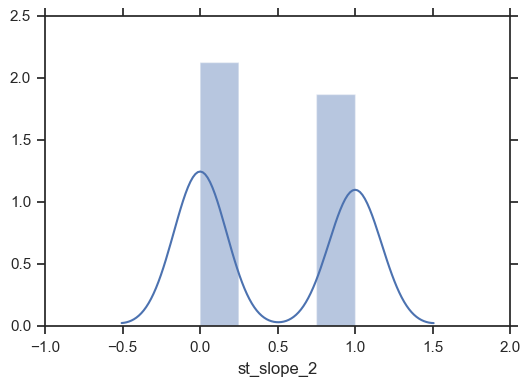

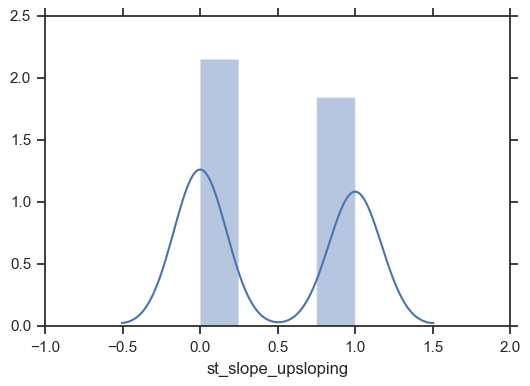

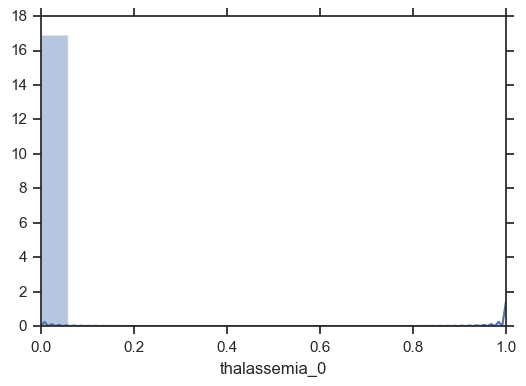

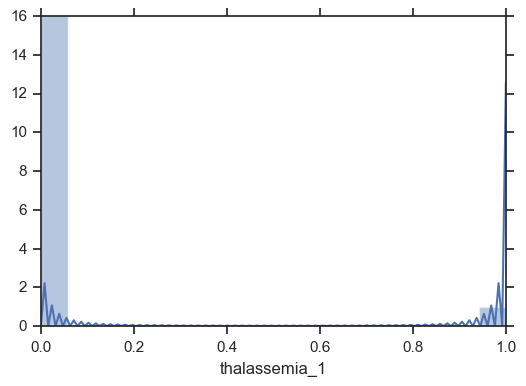

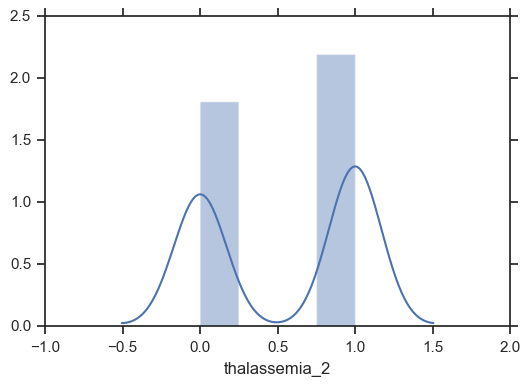

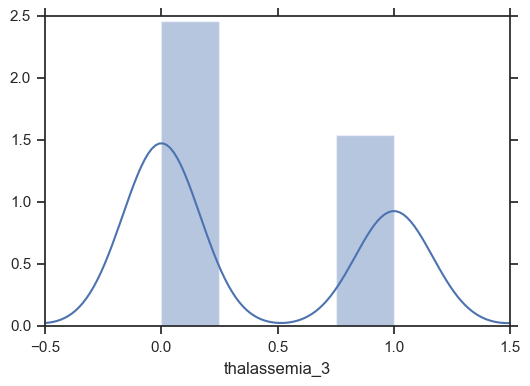

In [50]:
pd.set_option('display.max_rows', 50)
for column in hd.columns:
    sns.distplot(hd[column])
    plt.show()
    
# notice the imbalance in observations by sex

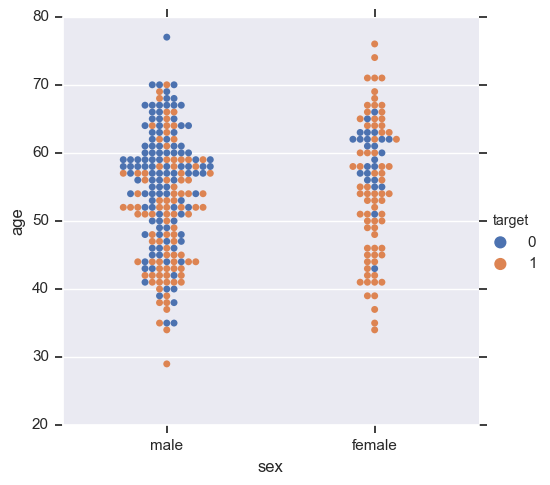

In [21]:
# explore demographic distribution
sns.catplot(x="sex", y="age", hue="target",
            kind="swarm", data=hd);
plt.show()

# women in the study appear to have a higher percentage of observations positive for heart disease
# both men and women in the study appear to have a higher probability of heart disease at a younger age

In [22]:
#dig further into the relationship between sex and heart disease
pd.crosstab(hd.sex, hd.target).apply(lambda r: r/r.sum(), axis=1)

# 75% of women in our dataset have heart disease
# only 45% of men have heart disease

target,0,1
sex,,
female,0.250000,0.750000
male,0.550725,0.449275


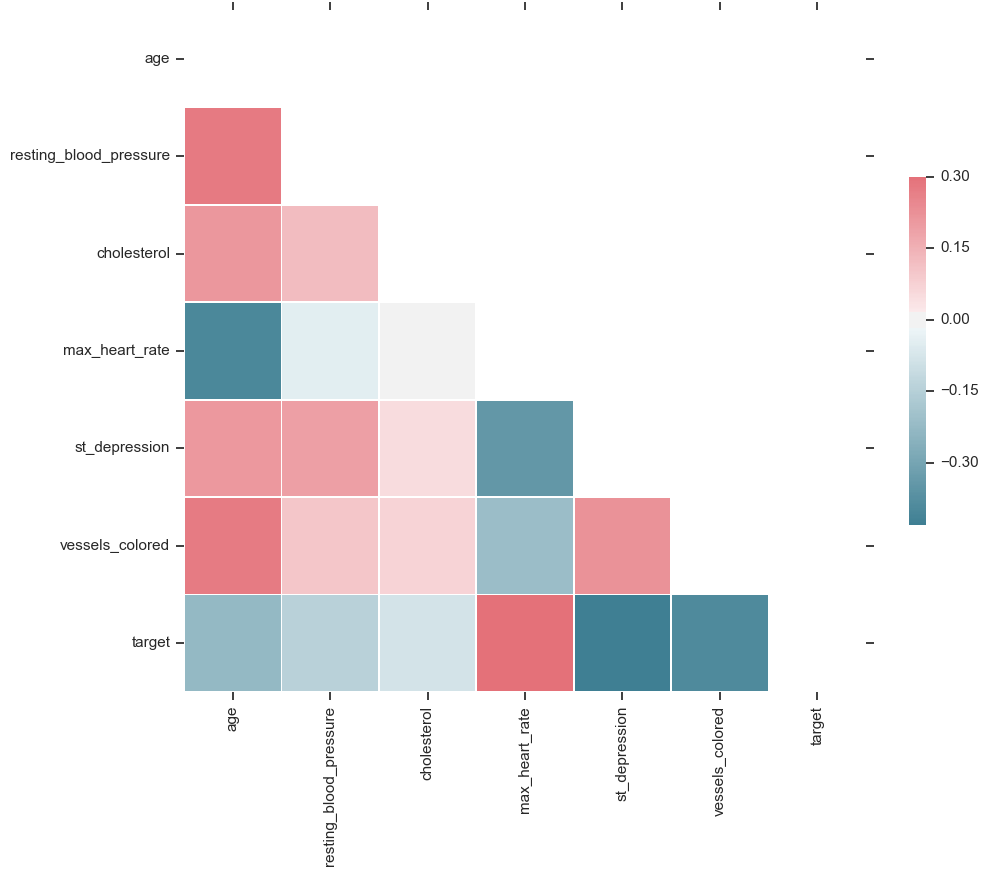

In [23]:
sns.set(style="white")

# Compute the correlation matrix
corr = hd.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# some moderate correlation present between:
# slope and oldpeak
# thalach and age
# exang and cp
# trestbps and age
# thalach and age
# oldpeak and exang
# slope and thalach

In [24]:
x = hd.drop('target',axis=1)
x.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,restecg,max_heart_rate,exercise_induced_angina,st_depression,st_slope,vessels_colored,thalassemia
0,63,male,non-anginal pain,145,233,fasting blood sugar gt 120 mg per dl,normal,150,no,2.3,0,0,1
1,37,male,atypical angina,130,250,fasting blood sugar ltoe 120 mg per dl,ST-T wave abnormality,187,no,3.5,0,0,2
2,41,female,typical angina,130,204,fasting blood sugar ltoe 120 mg per dl,normal,172,no,1.4,flat,0,2
3,56,male,typical angina,120,236,fasting blood sugar ltoe 120 mg per dl,ST-T wave abnormality,178,no,0.8,flat,0,2
4,57,female,0,120,354,fasting blood sugar ltoe 120 mg per dl,ST-T wave abnormality,163,yes,0.6,flat,0,2


In [5]:
y = hd['target']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [5]:
# apply dimensionality reduction to reduce features to 2 dimensions for plotting

# linear
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x)
x_pca = pca.transform(x)
x_pca.shape

NameError: name 'x' is not defined

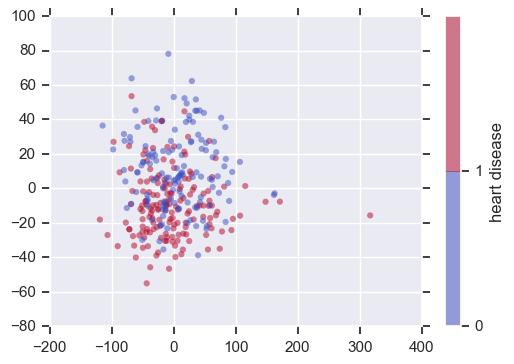

In [9]:
plt.scatter(x_pca[:,0], x_pca[:, 1], c=y, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('coolwarm',2))
plt.colorbar(label = 'heart disease',ticks=range(2))
plt.clim(0,2);
plt.show()

In [10]:
# nonlinear 
from sklearn.manifold import Isomap
iso=Isomap(n_components=2)
iso.fit(x)
data_projected = iso.transform(x)
data_projected.shape

(303, 2)

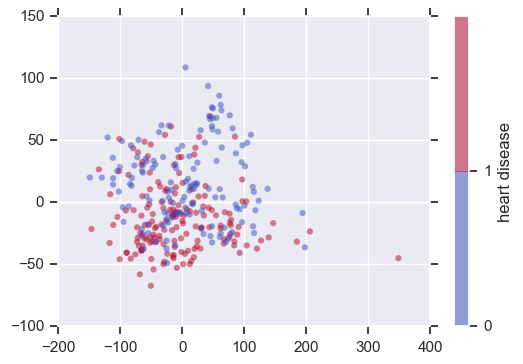

In [11]:
plt.scatter(data_projected[:,0], data_projected[:, 1], c=y, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('coolwarm',2))
plt.colorbar(label = 'heart disease',ticks=range(2))
plt.clim(0,2);
plt.show()

# Overall, the groups have some separation on the edges, but are not well separated in the center. 
# This will be a fun and challenging classification exercise

In [6]:
from sklearn.cross_validation import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(xtrain.shape[0], n_iter=10, test_size=0.2, random_state=0)

C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
# start with Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(xtrain, ytrain)
y_model = model.predict(xtest)

print(accuracy_score(ytest, y_model))

# even with this extremely simple model, we obtain accuracy of 83%

0.8524590163934426


In [10]:
#54% of observations in dataset are positive for heart disease. Our models should perform significantly above 54% to be useful.
hd.target.sum() / hd.target.count()

0.5445544554455446

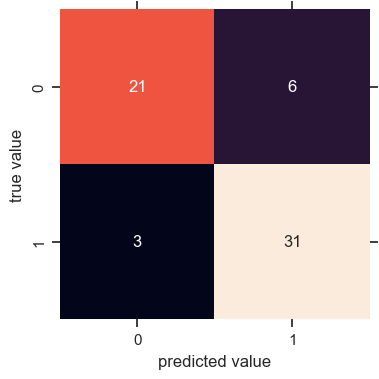

In [11]:
# examine errors with confusion matrix

mat = confusion_matrix(ytest, y_model)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

In [ ]:
# further tuning of naive bayes to improve performance

In [63]:
# try logistic regression

from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(random_state=0, multi_class='ovr', solver='liblinear', penalty='l1')
parameters = {
        'C': (0.01,0.1,0.5,0.9,0.99),
#        'multiclass': ('ovr','multinomial')
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

C 0.9
             precision    recall  f1-score   support

          0       0.85      0.81      0.83        27
          1       0.86      0.88      0.87        34

avg / total       0.85      0.85      0.85        61



In [74]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(random_state=0, penalty='l2')
parameters = {
        'multi_class': ('ovr','multinomial'),
        'solver': ('newton-cg','lbfgs'),
        'C': (0.01,0.1,0.5,0.9,0.99),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

C 0.99
multi_class ovr
solver lbfgs
             precision    recall  f1-score   support

          0       0.85      0.81      0.83        27
          1       0.86      0.88      0.87        34

avg / total       0.85      0.85      0.85        61



In [90]:
# support vector machines

from sklearn.svm import SVC

estimator = SVC(random_state=0, kernel='linear')
parameters = {
        'C': (0.01,0.05,0.1,0.5,0.9,0.99),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

C 0.05
             precision    recall  f1-score   support

          0       0.88      0.78      0.82        27
          1       0.84      0.91      0.87        34

avg / total       0.85      0.85      0.85        61



In [93]:
estimator = SVC(random_state=0)
parameters = {
        'C': (0.01,0.05,0.1,0.5,0.9,0.99),
        'kernel': ('rbf', 'sigmoid'),
        'gamma': (0.001,0.01,0.05,0.1,0.5,0.9),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

C 0.99
gamma 0.001
kernel rbf
             precision    recall  f1-score   support

          0       0.59      0.70      0.64        27
          1       0.72      0.62      0.67        34

avg / total       0.67      0.66      0.66        61



In [ ]:
estimator = SVC(random_state=0, kernel='poly')
parameters = {
        'C': (0.1,0.5,0.9),
        'degree': (2,3,4),
        'gamma': (0.1,0.5,0.9),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

In [51]:
# random forest

from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=0)
parameters = {
        'n_estimators': (10,50,100),
        'max_depth': (2,4,6,10),
        'min_samples_leaf': (2,3,5),
        'min_samples_split': (2,6,10),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

##model = RandomForestClassifier(n_estimators=1000, random_state=0)
##model.fit(xtrain,ytrain)
#ypred = model.predict(xtest)
##from sklearn import metrics
##y_model = model.predict(xtest)
##print(accuracy_score(ytest, y_model))
##print(metrics.classification_report(classifier.predict, ytest))
#mat = confusion_matrix(ytest, ypred)
#sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
#plt.xlabel('predicted value')
#plt.ylabel('true value')
#plt.show()

max_depth 2
min_samples_leaf 3
min_samples_split 2
n_estimators 50
             precision    recall  f1-score   support

          0       0.88      0.81      0.85        27
          1       0.86      0.91      0.89        34

avg / total       0.87      0.87      0.87        61



In [83]:
#linear discriminant analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

estimator = LinearDiscriminantAnalysis()
parameters = {
           'store_covariance': (0,0.01,0.1,0.5,0.9,1),
           'tol': (0.01,0.1,0.5,0.9,0.99),
           'n_components': (1,2,3,4,5)
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\

n_components 1
store_covariance 0
tol 0.9
             precision    recall  f1-score   support

          0       0.78      0.67      0.72        27
          1       0.76      0.85      0.81        34

avg / total       0.77      0.77      0.77        61



In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

estimator = LinearDiscriminantAnalysis()
parameters = {
           'solver': ('lsqr','eigen'),
           'shrinkage': (0,0.01,0.1,0.5,0.9,1),
           'n_components': (1,2,3,4,5)
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

#model = LinearDiscriminantAnalysis(n_components=1)
#model.fit(xtrain, ytrain)
#y_model = model.predict(xtest)
#accuracy_score(ytest, y_model)

n_components 1
shrinkage 0
solver eigen
             precision    recall  f1-score   support

          0       0.86      0.70      0.78        27
          1       0.79      0.91      0.85        34

avg / total       0.83      0.82      0.82        61



In [49]:
#gradient boosted machine

from sklearn.ensemble import GradientBoostingClassifier
estimator = GradientBoostingClassifier(random_state=0)
parameters = {
           'n_estimators': (5,10,25,75,100),
           'learning_rate': (0.01,0.1,0.5,0.9,0.95),
           'max_features': (1,2,3,4,5),
           'max_depth': (1,2,3,4,5)
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

#learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
#scores = {}
#scores_list = []
#for l in learning_rates:
#    model = GradientBoostingClassifier(n_estimators=20, learning_rate = l, max_features=2, max_depth = 2, random_state = 0)
#    model.fit(xtrain, ytrain)
    ##print("Learning rate: ", learning_rate)
    ##print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_sub, y_train_sub)))
    ##print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation_sub, y_validation_sub)))
    ##print()
#    y_model = model.predict(xtest)
#    scores[l] = accuracy_score(ytest, y_model)
#    scores_list.append(accuracy_score(ytest, y_model))
#print(scores_list)

learning_rate 0.5
max_depth 1
max_features 4
n_estimators 10
             precision    recall  f1-score   support

          0       0.85      0.81      0.83        27
          1       0.86      0.88      0.87        34

avg / total       0.85      0.85      0.85        61



In [81]:
#knn

from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier()
parameters = {
           'n_neighbors': (2,6,10,15,20,25),
           'leaf_size': (1,2,3,4,5)
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

#k_range = range(1,26)
#scores = {}
#scores_list = []
#for k in k_range:
#    model = KNeighborsClassifier(n_neighbors=k)
#    model.fit(xtrain,ytrain)
#    y_model = model.predict(xtest)
#    scores[k] = accuracy_score(ytest, y_model)
#    scores_list.append(accuracy_score(ytest, y_model))
#print(scores_list)

leaf_size 1
n_neighbors 20
             precision    recall  f1-score   support

          0       0.62      0.78      0.69        27
          1       0.78      0.62      0.69        34

avg / total       0.71      0.69      0.69        61



In [86]:
#Stochastic gradient descent

from sklearn.linear_model import SGDClassifier

estimator = SGDClassifier(random_state=0, penalty='elasticnet')
parameters = {
           'loss': ('hinge','modified_huber','squared_hinge','perceptron'),
           'alpha': (0.0001,0.001,0.1,0.5,0.9),
           'l1_ratio': (0,0.1,0.5,0.9,1),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

alpha 0.9
l1_ratio 0.9
loss squared_hinge
             precision    recall  f1-score   support

          0       0.67      0.37      0.48        27
          1       0.63      0.85      0.72        34

avg / total       0.65      0.64      0.61        61



In [ ]:
#other notes
#are there models where the vars should be scaled?
#how should we scale weights for each class
